<a href="https://colab.research.google.com/github/deeyeet/phantom_dimensionality_reduction/blob/main/train_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [397]:
from google.colab import drive # connect to Google drive to access files
drive.mount('/content/gdrive')

import scipy.io as sio
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [398]:
phantom_imgs = sio.loadmat('/content/gdrive/My Drive/matlab_code/imageVectors.mat')
print(sorted(phantom_imgs.keys()))

G = phantom_imgs['G']
GTest = phantom_imgs['GTest']
g = phantom_imgs['g']
mSize = phantom_imgs['mSize'][0][0]
nx = phantom_imgs['nx'][0][0]
ny = phantom_imgs['ny'][0][0]
x_train = np.transpose(phantom_imgs['x']) # 30 x 4096, one image per row
x_test = np.transpose(phantom_imgs['xTest']) # 1 x 4096, single image row


N, D = x_train.shape


['G', 'GTest', 'Gb', '__globals__', '__header__', '__version__', 'g', 'mSize', 'nx', 'ny', 'x', 'xTest']


In [399]:
class PhantomImagesDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx]
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [400]:


class AE(nn.Module):
    def __init__(self, input_shape, hidden_size):
        super().__init__()
        self.encoder = nn.Linear(in_features=input_shape, out_features=hidden_size)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=input_shape)

    def forward(self, features):
        activation = nn.LogSigmoid()
        # encode the input to lower dimension
        encoded_img = activation(self.encoder(features))

        # decode the input to original dimension
        decoded_img = activation(self.decoder(encoded_img))
        return decoded_img


In [401]:
# Parameters
epochs = 1000
learning_rate = 1e-3
batch_size = 30
hidden_size = 100
sparsity_prop = 0.05
sparsity_reg = 1

In [402]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = PhantomImagesDataset(x_train)

test_set = PhantomImagesDataset(x_test)

# trainloader
trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=False
)
# testloader
testloader = DataLoader(
    test_set, 
    batch_size=1
)

'''
for i, data in enumerate(trainloader):
  print(data['image'].shape)
  sample_train_img = data['image'][29].reshape((nx, ny))
  sample_img_plot = plt.imshow(sample_train_img, cmap='gray')
  break
'''

"\nfor i, data in enumerate(trainloader):\n  print(data['image'].shape)\n  sample_train_img = data['image'][29].reshape((nx, ny))\n  sample_img_plot = plt.imshow(sample_train_img, cmap='gray')\n  break\n"

In [403]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
# model = AE(input_shape=D, hidden_size=hidden_size).to(device)
model = AE(input_shape=D, hidden_size=hidden_size).to(device)

# create an optimizer object
# SGD optimizer with learning rate 1e-3 and L2 regularization 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

# mean-squared error loss
criterion = nn.MSELoss()

# get the layers as a list
model_children = list(model.children())

In [404]:
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(F.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))
    
# define the sparse loss function
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

In [405]:
# define the training function
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader):
        counter += 1

        # construct image
        img = data['image']
        img = img.to(device).float()

        optimizer.zero_grad()
 
        # execute AE model
        outputs = model(img)

        # calculate losses
        mse_loss = criterion(outputs, img)
        sparsity = sparse_loss(sparsity_prop, img)
        loss = mse_loss + sparsity_reg * sparsity

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    # print(f"Train Loss: {epoch_loss:.3f}")
    return epoch_loss

In [406]:
# define the test function
def test(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1

            # construct image
            img = data['image']
            img = img.to(device).float()

            # execute AE model
            outputs = model(img)

            # calculate loss
            loss = criterion(outputs, img)
            running_loss += loss.item()
            print("hi")
    epoch_loss = running_loss / counter
    print(f"Val Loss: {epoch_loss:.3f}")   
    return outputs, epoch_loss

In [407]:
# train and validate the autoencoder neural network
train_loss = []
val_loss = []

start = time.time()
for epoch in range(epochs):
    # print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, trainloader)
    train_loss.append(train_epoch_loss)
end = time.time()
print(f"{(end-start)/60:.3} minutes")

# use test images
reconstructed, test_loss = test(model, testloader)
print(reconstructed.shape)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0846 minutes
Validating
hi
Val Loss: 0.114
torch.Size([1, 4096])


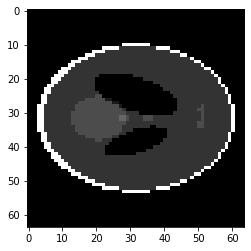

In [408]:
orig_img = x_test.reshape((nx, ny))
orig_img_plot = plt.imshow(orig_img, cmap='gray')

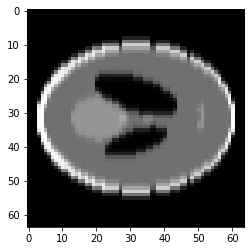

In [409]:
new_img = reconstructed.view(nx, ny).cpu().data
new_img_plot = plt.imshow(new_img, cmap='gray')